# **Part 2.B Solutions Notebook** 

In [ ]:
from IPython.display import Image,display,HTML
import cv2
import scipy.stats as stats
import statistics
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn import linear_model

### Reading operations of the image

In [ ]:
image = cv2.imread('image9.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

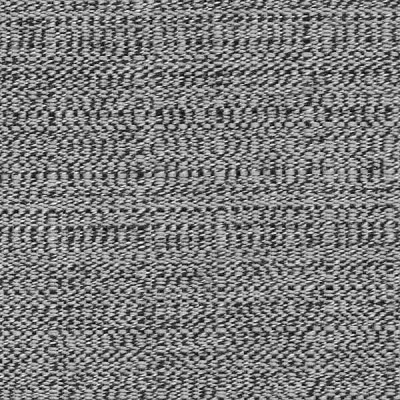

In [ ]:
cv2.imwrite('image9_gray.jpg', gray) 
Image(filename='image9_gray.jpg')

### Splitting image into 51x51 patches

We are shifting windows of size 51x51 "4" pixels everytime starting from the top left corner of the image to get our training data for building the linear regression model.

In [ ]:
starting_x=0 #initialization of starting x coordinate
starting_y=0 #initialization of starting y coordinate
patch_number=87*87
number_of_predictors=(51*51)-1
y=np.arange(patch_number)
x=np.zeros((patch_number,number_of_predictors))
for i in range(patch_number): #repeating the process for total number of patches(last 1 pixel isn't considered at each dimension)
    gray_patch=gray[starting_x:(starting_x+51),starting_y:(starting_y+51)]   #selecting the patch
    y[i]=gray_patch[25,25]                                                   #selecting the central pixel
    x[i]=np.array(np.delete(gray_patch,1300))                                #finding predictors
    starting_x=starting_x+4 
    if starting_x==348:
        starting_y=starting_y+4
        starting_x=0
        if starting_y==348:
            break

We are shifting windows of 51x51 "1" pixels everytime starting from the top left corner of the image to get the necessary input to predict the center pixels with the constructed linear regression model. 

In [ ]:
starting_x=0 #initialization of starting x coordinate
starting_y=0 #initialization of starting y coordinate
patch_number=350*350
number_of_predictors=(51*51)-1
y_pred=np.arange(patch_number)
x_pred=np.zeros((patch_number,number_of_predictors))
for i in range(patch_number): #repeating the process for total number of patches(last 2 pixels isn't considered)
    gray_patch=gray[starting_x:(starting_x+51),starting_y:(starting_y+51)] #selecting the patch
    y_pred[i]=gray_patch[25,25]
    x_pred[i]=np.array(np.delete(gray_patch,1300))
    starting_x=starting_x+1
    if starting_x==350:
        starting_y=starting_y+1
        starting_x=0
        if starting_y==350:
            break

### Building the linear regression model

We are building the model using the first data set and then we predict the center pixels of the second data set.

In [ ]:
lm=linear_model.LinearRegression()
model =lm.fit(x,y)
predictions=lm.predict(x_pred)

### Plotting the residuals

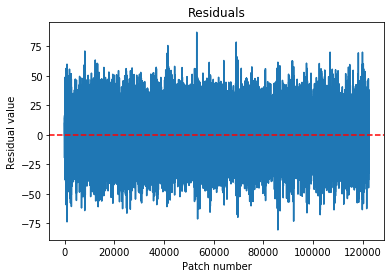

In [ ]:
residuals=y_pred-predictions

plt.figure()
plt.title('Residuals')
plt.plot(residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Patch number')
plt.ylabel('Residual value')
plt.show()

### Plotting the Q-Q plot of the residuals

With the below code we are plotting Q-Q plot of residuals for normal distribution. We can clearly see that observed values and theoretical quantiles are highly close which leads the conclusion that residuals are approximately normally distributed.

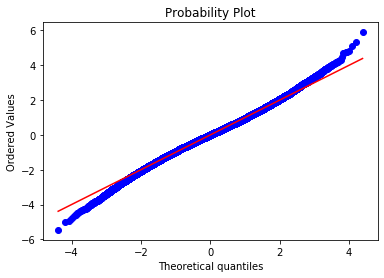

In [ ]:
residual_mean=np.mean(residuals)
residual_std=np.std(residuals)
residual_normalized=(residuals-residual_mean)/(residual_std)

stats.probplot(residual_normalized, dist="norm", plot=plt)
plt.show()

### X-bar chart of the residuals

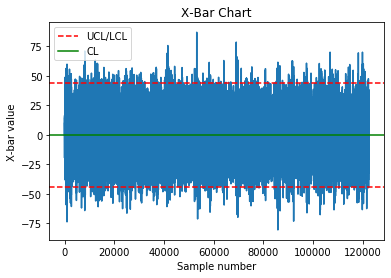

In [ ]:
residual_mean=np.mean(residuals)
residual_std=np.std(residuals)
upper_limit=residual_mean+3*residual_std
lower_limit=residual_mean-3*residual_std
central_line=residual_mean

plt.figure()
plt.title('X-Bar Chart')
plt.xlabel('Sample number')
plt.ylabel('X-bar value')
plt.plot(residuals)
plt.axhline(upper_limit,color="r", linestyle='--', label='UCL/LCL')
plt.axhline(lower_limit,color="r", linestyle='--')
plt.axhline(central_line,color="g", label='CL')
plt.legend()
plt.show()

### Updating the image by setting the outlier values to 0 (black pixel)

In [ ]:
gray_updated=np.copy(gray)
outliers=np.where((residuals>upper_limit)|(residuals<lower_limit))
for i in outliers[0]: #replacing the outliers with 0
    gray_updated[25+(i%350),25+int(i/350)]=0
print("Number of Outlier Pixels={}".format(len(outliers[0])))

Number of Outlier Pixels=764


The process captures center pixels that are most different than their surrounding pixels (outliers) in each patch and replaces them with a black pixel, since the process didn't find significant number of outliers (764 at total) the modified image (upper image) and the original greyscale image looks very much alike.
However, we are also assuming that predictors which are the surrounding pixels in each patch are independent from each other when we build our multiple linear regression model which is not a very accurate assumption. Therefore we are able to get unrealistically good predictions for center pixels and reach very low number of outliers in x-bar control chart for residuals.

### Comparison of original and updated images

'Updated Image:'

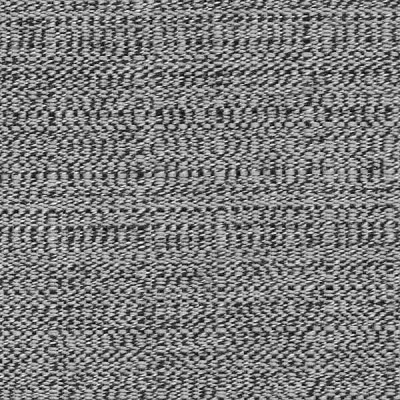

'Original Image'

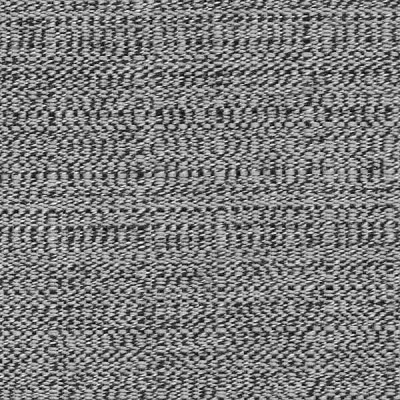

In [ ]:
cv2.imwrite('image9_gray_updated.jpg', gray) 
display('Updated Image:',Image(filename='image9_gray_updated.jpg'),'Original Image',Image(filename='image9_gray.jpg'))

### Alternative approaches

The maximum value of a pixel in gray scale is 255 and the minimum value is 0. In order to reduce the effects of autocorrelation, we can use total number of pixels for each value in the window instead of using each pixel's value. This way number of features in the model decreases to 256 (instead of 51x51-1=2600 features). So the model becomes like:
* _y = β<sub>0</sub> + β<sub>1</sub>\*x<sub>0</sub> + β<sub>2</sub>\*x<sub>1</sub> + ... + β<sub>256</sub>\*x<sub>255</sub>_

where: 
* _x<sub>i</sub> = number of pixels with value i in the window for i=0,1,...,255_

However in this case we lose the information of location of the pixels completely. Therefore, we can include the location information to the model by considering the location of centroid of the corresponding pixels (mean of the pixels' locations). Closer pixels' effect is expected to be higher by intuition so we consider the distance between centroid's location and the center location of the window (25x25). Let's call that distance for pixel value i as **d<sub>i</sub>**. Then we introduce new features which are equal _**w<sub>i</sub> = 1/d<sub>i</sub>**_ for i = 0,1,...,255.

Finally, the model becomes:
* _y = β<sub>0</sub> + β<sub>1</sub>\*x<sub>0</sub> + β<sub>2</sub>\*x<sub>1</sub> + ... + β<sub>256</sub>\*x<sub>255</sub> + λ<sub>1</sub>\*w<sub>0</sub> + λ<sub>2</sub>\*w<sub>1</sub> + ... + λ<sub>256</sub>\*w<sub>255</sub>_

where:
* _x<sub>i</sub> = number of pixels with value i in the window for i=0,1,...,255_
* _w<sub>i</sub> = distance between centroid of the pixels with value i and center cell (25x25) for i=0,1,...,255_

> **NOTE:** The source code is available at [here.](https://github.com/BU-IE-582/fall19-akinelden/blob/master/Project_Part2/Part2_B.ipynb)